# Image Segmentation Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


### Download the Videos

In [2]:
# # Getting the video files
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

File ‘ua_detrac.mp4’ already there; not retrieving.


### Load sample video from DAVIS dataset for analysis

In [3]:
cursor.query('DROP TABLE IF EXISTS VideoForSegmentation;').df()
cursor.query('LOAD VIDEO "ua_detrac.mp4" INTO VideoForSegmentation;').df()

,0
0,Number of loaded VIDEO: 1


### Register Hugging Face Segmentation Model as an User-Defined Function (UDF) in EvaDB 

In [4]:
### Using HuggingFace with EvaDB requires specifying the task
### The task here is 'image-segmentation'
### The model is 'facebook/detr-resnet-50-panoptic'
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS HFSegmentation
    TYPE HuggingFace
    TASK 'image-segmentation'
    MODEL 'facebook/detr-resnet-50-panoptic';
""").df()

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor conf

,0
0,Function HFSegmentation successfully added to ...


### Run Image Segmentation on the video

In [5]:
response = cursor.query("""
    SELECT HFSegmentation(data)
    FROM VideoForSegmentation SAMPLE 5
    WHERE id < 20
""").df()

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor conf

### Visualizing output of the Image Segmenter on the video

In [6]:
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

def get_color_mapping(all_labels):
    unique_labels = set(label for labels in all_labels for label in labels)
    num_colors = len(unique_labels)
    colormap = plt.colormaps["tab20"]
    colors = [colormap(i % 20)[:3] for i in range(num_colors)]
    colors = [tuple(int(c * 255) for c in color) for color in colors]
    color_mapping = {label: color for label, color in zip(unique_labels, colors)}
    return  color_mapping

def annotate_single_frame(frame, segments, labels, color_mapping):
    overlay = np.zeros_like(frame)

    # Overlay segments
    for mask, label in zip(segments, labels):
        mask_np = np.array(mask).astype(bool)
        overlay[mask_np] = color_mapping[label]

    # Combine original frame with overlay
    new_frame = Image.blend(
        Image.fromarray(frame.astype(np.uint8)),
        Image.fromarray(overlay.astype(np.uint8)),
        alpha=0.5,
    )

    return new_frame

def annotate_video(segmentations, input_video_path, output_video_path, model_name = 'hfsegmentation'):
    all_segments = segmentations[f'{model_name}.mask']
    all_labels = segmentations[f'{model_name}.label']


    color_mapping = get_color_mapping(all_labels)

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    ret, frame = vcap.read() 
    while ret and frame_id < len(all_segments):
        segments = all_segments[frame_id]
        labels = all_labels[frame_id]
        new_frame = annotate_single_frame(frame, segments, labels, color_mapping)
        video.write(np.array(new_frame))
        if frame_id % 5 == 0:
            legend_patches = [mpatches.Patch(color=np.array(color_mapping[label])/255, label=label) for label in set(labels)]
            plt.imshow(new_frame)
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.axis('off')
            plt.tight_layout()
            plt.show()


        frame_id += 1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

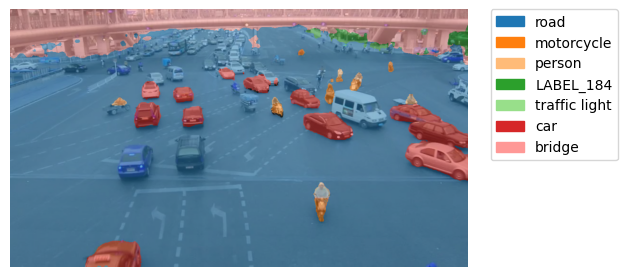

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x01\xb8\xd2...')

In [7]:
from ipywidgets import Video
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)

### Drop functions

In [8]:
cursor.query("DROP FUNCTION HFSegmentation").df()

,0
0,Function HFSegmentation successfully dropped
